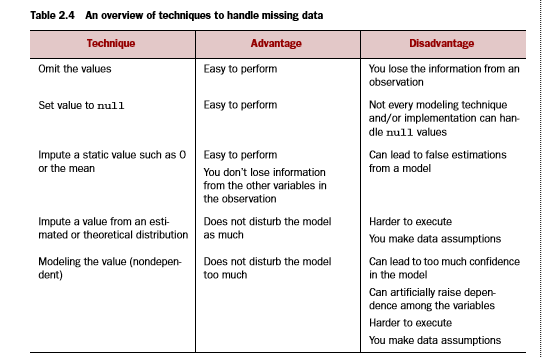

In [3]:
from IPython.display import Image 
Image("missing_value.png")


## Printing the percentage of missing values per column

In [ ]:

def percent_missing(dataframe):
    '''
    Prints the percentage of missing values for each column in a dataframe
    '''
    # Summing the number of missing values per column and then dividing by the total
    sumMissing = dataframe.isnull().values.sum(axis=0)
    pctMissing = sumMissing / dataframe.shape[0]
    
    if sumMissing.sum() == 0:
        print('No missing values')
    else:
        # Looping through and printing out each columns missing value percentage
        print('Percent Missing Values:', '\n')
        for idx, col in enumerate(dataframe.columns):
            if sumMissing[idx] > 0:
                print('{0}: {1:.2f}%'.format(col, pctMissing[idx] * 100))
        

## Plotting missing values

In [ ]:
import missingno as msno  # Visualizes missing values
msno.matrix(df)
msno.heatmap(df)  # Co-occurrence of missing values

# Drop missing values
df.dropna(how='any', thresh=None, inplace=True)  # Also 'all' for how, and thresh is an int

# Filling missing values with columnar means
df.fillna(value=df.mean(), inplace=True)

# Filling missing values with interpolation
df.fillna(method='ffill', inplace=True)  #'backfill' for interpolating the other direction


## Filling missing values with a predictive model

In [ ]:

def predict_missing_values(data, column, correlationThresh=0.5, cross_validations=3):
    '''
    Fills missing values using a random forest model on highly correlated columns
    Returns a series of the column with missing values filled
    
    To-do: - Add the option to specify columns to use for predictions
           - Look into other options for handling missing predictors
    '''
    from sklearn.model_selection import cross_val_score
    from sklearn import ensemble
    
    # Printing number of percentage values missing
    pctMissing = data[column].isnull().values.sum() / data.shape[0]
    print('Predicting missing values for {0}\n'.format(column))
    print('Percentage missing: {0:.2f}%'.format(pctMissing*100))
    
    # Multi-threading if the dataset is a size where doing so is beneficial
    if data.shape[0] < 100000:
        num_cores = 1  # Single-thread
    else:
        num_cores = -1  # All available cores
    
    # Instantiating the model
    # Picking a classification model if the number of unique labels are 25 or under
    num_unique_values = len(np.unique(data[column]))
    if num_unique_values > 25 or data[column].dtype != 'category':
        print('Variable is continuous')
        rfImputer = ensemble.RandomForestRegressor(n_estimators=100, n_jobs=num_cores)
    else:
        print('Variable is categorical with {0} classes').format(num_unique_values)
        rfImputer = ensemble.RandomForestClassifier(n_estimators=100, n_jobs=num_cores)
    
    # Calculating the highly correlated columns to use for the model
    highlyCorrelated = abs(data.corr()[column]) >= correlationThresh
    
    # Exiting the function if there are not any highly correlated columns found
    if highlyCorrelated.sum() < 2:  # Will always be 1 because of correlation with self
        print('Error: No correlated variables found. Re-try with less a lower correlation threshold')
        return  # Exits the function
    highlyCorrelated = data[data.columns[highlyCorrelated]]
    highlyCorrelated = highlyCorrelated.dropna(how='any')  # Drops any missing records
    print('Using {0} highly correlated features for predictions\n'.format(highlyCorrelated.shape[1]))
    
    # Creating the X/y objects to use for the
    y = highlyCorrelated[column]
    X = highlyCorrelated.drop(column, axis=1)
    
    # Evaluating the effectiveness of the model
    cvScore = np.mean(cross_val_score(rfImputer, X, y, cv=cross_validations, n_jobs=num_cores))
    print('Cross Validation Score:', cvScore)

    # Fitting the model for predictions and displaying initial results
    rfImputer.fit(X, y)
    if num_unique_values > 25 or data[column].dtype.name != 'category':
        print('R^2:', rfImputer.score(X, y))
    else:
        print('Accuracy:', rfImputer.score(X, y))
    
    # Re-filtering the dataset down to highly correlated columns
    # Filling NA predictors w/ columnar mean instead of removing
    X_missing = data[highlyCorrelated.columns]
    X_missing = X_missing.drop(column, axis=1)
    X_missing = X_missing.fillna(X_missing.mean())
    
    # Filtering to rows with missing values before generating predictions
    missingIndexes = data[data[column].isnull()].index
    X_missing = X_missing.iloc[missingIndexes]
    
    # Predicting the missing values
    predictions = rfImputer.predict(X_missing)
    
    # Preventing overwriting of original dataframe
    data = data.copy()

    # Looping through the missing values and replacing with predictions
    for i, idx in enumerate(missingIndexes):
        data.set_value(idx, column, predictions[i])
    
    return data[column]

    
df[colName] = predict_missing_values(df, colName)

# What do to with missing data?

* Remove them via .dropna(axis=0)
* Fill them with some arbitary number (e.g. an average)
* Filll them zeros, or Forward Fill (ffill) or Back Fill (backfill)

# ISNULL

In [ ]:
#  Find Null Values or Check for Null Values

import pandas as pd
import numpy as np
df2 = pd.DataFrame({'col1':[1,2,3,4],'col2':[444,555,666,444],'col3':['abc','def',np.nan,'xyz']})
#print(df2)
print('---------------Check Null in full dataframe--------------')
df.isnull()
# to check the count of nulls in columns
df.isnull().sum()

# Boolean result of null
print((df2['col3'].isnull()))

# tells which row of that column has null
print((df2[df2['col3'].isnull()]))

# Check the percentage of missing values
# how many total missing values do we have?
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
(total_missing/total_cells) * 100

# FILLNA

In [ ]:
df.fillna(value='Fill value')
# we can directly fillna with value =0 
df['SoldFlag'].fillna(0,inplace=True)
# TO replace the null with mode in  Categorical value
# Check for mode
df['SoldCount'].fillna(df['SoldCount'].mean(), inplace=True)
df['SoldCount'].fillna(value=df['SoldCount'].mean())
df['SoldCount'].isnull().sum()
# OR
# df['Product_Type'].fillna(0),inplace=True)
df['SoldFlag'].fillna(df['SoldFlag'].mode()[0],inplace=True)) ## how to fill mode value direct
## [0] means we give the index=0 to run the value this used when 3 mode find then we used index to fill
df['Product_Type'].isnull().sum()

# -----------------------COrrect Way--------------------------
# we have given iloc =0 becos we are selecting the ist  mode with highest frequency
# For one column
#df[cols]=df[cols].fillna(mode.iloc[0])
# for multiple column
#cols = ["workclass", "native-country"]
#df[cols]=df[cols].fillna(df.mode().iloc[0])
cols=['Gender','Married']
df_new[cols]=df[cols].fillna(df.mode().iloc[0])

# FFILL,BFILL

In [ ]:
# Let's try filling with forward and backward
#Replace them with Forward Fill (ffill) or Back Fill (backfill)
# Forward fill= fill with one previous value
# Backward fill= fill with one next value
import numpy as np
import pandas as pd
df = pd.DataFrame({'A':[1,2,np.nan,3,11,22,78],
                  'B':[5,np.nan,np.nan,np.nan,np.nan,np.nan,7],
                  'C':[1,2,3,np.nan,np.nan,13,65],
                  'd':[4,5,6,7,8,9,10],
                  'e':[np.nan,np.nan,np.nan,33,44,55,66]})
print(df)
print()
print("Forward fill \n",df['A'].fillna(method='ffill').head())
print()
print("Backward fill \n",df['A'].fillna(method='bfill').head())

# DROP & DROPNA

In [ ]:
# What makes more sense to me is to say it this way:

# Axis 0 will act on all the ROWS in each COLUMN
# Axis 1 will act on all the COLUMNS in each ROW
# Drop a range of rows
# default axis=0 = row wise
# axis=1 , column wise

# To drop any one Row, Here  we are dropping 0th index row
# for rows need not to axis becos bydefault it is 0 or row or index.


# ---------------------------DROP ROWS---------------------------------------

df = df.drop(df.index[0])
or 
df.drop(index=0)
or
df.drop([0])

df = df.reset_index()
df.head()
# To drop multiple Rows,Here we are dropping 2 and 3 th index row
## If we want to remove 1 and 10th row
df = df.drop(df.index[[2,3]])
or
df.drop([2,3])
or
df.drop(index=2|3)


df.head()
# To drop range of Rows
df = df.drop(df.index[1:4])
df.head()
# OR For Range
# to get dropped values range this syntax
print(df[2:5].drop)

# -------------------------------DROP COLUMN-------------------------------------

# Drop a one of selected columns
print(df.drop(columns='Number of Doors'))
or
df.drop(['Number of Doors'],axis=1)

# Multiple columns
df.drop(columns=['a','b'])
or
df.drop(['a','b'],axis=1)
df.drop(["year", "date"], axis=1)

# if we want to make it permanent delete then put inplace=true , bydefault it is false. 
print(df.drop(columns='Number of Doors', inplace=True))
# OR
# Also same work as ---> df=df.drop(Columns='Number of Doors')
# OR
# Also same work as ---> del df['Number of Doors']
# OR
# df.drop('Packing sizes', axis=1,inplace=True)


# --------------------------------DROP NULL---------------------------------

# drop full row with any null value present in that roww.
# Drop the row where at least one element is missing.
print(df.dropna())    # bydefault axis=0

# drop full column if  any null values present in that column.
# Drop the columns where at least one element is missing.
print(df.dropna(axis=1))
or
df.dropna(axis='columns')

#Drop the rows where all elements are missing or null.
df.dropna(how='all')

#Drop the rows where if any of the elements are missing or null.
df.dropna(how='any')

# To check which columns has how many null values
df.isnull().sum()

# -------------COrrect Way----------------------------
# Subset check it only on rows if any row of given column has na it will delete that complete row. Only to drop rows .
# axis=0 is optional becos bydefault axis=0
# subset is for giving particular column name with nan & will  drop that row. 
df.dropna(subset=['b','c'])
df.dropna(subset=['b','c'],how='any')

# to drop null of any particular column
df.dropna(subset=['InvoiceNo'],axis=0, inplace=True)

# to drop na from any selected column only
df = df.dropna(axis=0, subset=['Credit_History'])

# THRESH

In [ ]:
import numpy as np
import pandas as pd
df = pd.DataFrame({'A':[1,2,np.nan,3,11,22,78],
                  'B':[5,np.nan,np.nan,np.nan,np.nan,np.nan,7],
                  'C':[1,2,3,np.nan,np.nan,13,65],
                  'd':[4,5,6,7,8,9,10],
                  'e':[np.nan,np.nan,np.nan,33,44,55,66]})
print(df)
# show those rows where atleast 4 non null values are present.
# Or it drops rows whose values dont have 4 non null values or have less than threhold.
print(df.dropna(thresh=4))

In [ ]:
Signature:
df.drop(
    labels=None,
    axis=0,
    index=None,
    columns=None,
    level=None,
    inplace=False,
    errors='raise',
)
Docstring:
Drop specified labels from rows or columns.

Remove rows or columns by specifying label names and corresponding
axis, or by specifying directly index or column names. When using a
multi-index, labels on different levels can be removed by specifying
the level.

Parameters
----------
labels : single label or list-like
    Index or column labels to drop.
axis : {0 or 'index', 1 or 'columns'}, default 0
    Whether to drop labels from the index (0 or 'index') or
    columns (1 or 'columns').
index : single label or list-like
    Alternative to specifying axis (``labels, axis=0``
    is equivalent to ``index=labels``).

    .. versionadded:: 0.21.0
columns : single label or list-like
    Alternative to specifying axis (``labels, axis=1``
    is equivalent to ``columns=labels``).

    .. versionadded:: 0.21.0
level : int or level name, optional
    For MultiIndex, level from which the labels will be removed.
inplace : bool, default False
    If True, do operation inplace and return None.
errors : {'ignore', 'raise'}, default 'raise'
    If 'ignore', suppress error and only existing labels are
    dropped.
Examples
--------
>>> df = pd.DataFrame(np.arange(12).reshape(3, 4),
...                   columns=['A', 'B', 'C', 'D'])
>>> df
   A  B   C   D
0  0  1   2   3
1  4  5   6   7
2  8  9  10  11

Drop columns

>>> df.drop(['B', 'C'], axis=1)
   A   D
0  0   3
1  4   7
2  8  11

>>> df.drop(columns=['B', 'C'])
   A   D
0  0   3
1  4   7
2  8  11

Drop a row by index

>>> df.drop([0, 1])
   A  B   C   D
2  8  9  10  11

Drop columns and/or rows of MultiIndex DataFrame

>>> midx = pd.MultiIndex(levels=[['lama', 'cow', 'falcon'],
...                              ['speed', 'weight', 'length']],
...                      codes=[[0, 0, 0, 1, 1, 1, 2, 2, 2],
...                             [0, 1, 2, 0, 1, 2, 0, 1, 2]])
>>> df = pd.DataFrame(index=midx, columns=['big', 'small'],
...                   data=[[45, 30], [200, 100], [1.5, 1], [30, 20],
...                         [250, 150], [1.5, 0.8], [320, 250],
...                         [1, 0.8], [0.3, 0.2]])
>>> df
                big     small
lama    speed   45.0    30.0
        weight  200.0   100.0
        length  1.5     1.0
cow     speed   30.0    20.0
        weight  250.0   150.0
        length  1.5     0.8
falcon  speed   320.0   250.0
        weight  1.0     0.8
        length  0.3     0.2

>>> df.drop(index='cow', columns='small')
                big
lama    speed   45.0
        weight  200.0
        length  1.5
falcon  speed   320.0
        weight  1.0
        length  0.3

>>> df.drop(index='length', level=1)
                big     small
lama    speed   45.0    30.0
        weight  200.0   100.0
cow     speed   30.0    20.0
        weight  250.0   150.0
falcon  speed   320.0   250.0
        weight  1.0     0.8
    

# DESCRIPTIVE STATS

In [ ]:
# Descriptive statistics on dataframe by default axis=0 means column wise
# Specifying the axies
# mean
print(df['StrengthFactor'].mean())
or
df.loc[:,'StrengthFactor'].mean()

# Note Axis = 0 is used by default and calculates the column statistics
print(df[['Order','Product_ID']].mean())
or
df.loc[:,['Order','Product_ID']].mean()

# if we use axis = 1, we are calculating the row statistics
print(df[['Order','Product_ID']].mean(axis=1))
or
df.loc[:,['Order','Product_ID']].mean(axis=1)

# Mean with range of rows
print(df['StrengthFactor'].iloc[0:19].mean())
or
df.loc[:,'StrengthFactor'].iloc[0:19].mean(axis=1)

# Mean of the dataframe all columns which have numerical values.
print(df.mean(numeric_only=True))

In [ ]:
# we got 3 modes becos they have same frequency
print(df['StrengthFactor'].mode())
print()
# mode
print(df['SoldFlag'].mode())

print("Mean = " + str(df['age'].mean()))
print("Median = " + str(df['age'].median()))
print("Mode = " + str(getMode(df, 'age')))

In [ ]:
# Median
print(df['StrengthFactor'].median())
# median
print(df['SoldFlag'].median())